In [1]:
# Project №1, задание №1, Испрвления после 1ой проверки:

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [3]:
# данные о времени регистрации
reg_df = pd.read_csv('~/shared/problem1-reg_data.csv', sep = ';')
reg_df.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [4]:
# Данные о времени захода пользователей в игру
auth_df = pd.read_csv('~/shared/problem1-auth_data.csv', sep = ';')
auth_df.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [5]:
# Преобразуем столбцы с временем в формат даты

auth_df["auth_ts"] = pd.to_datetime(auth_df["auth_ts"], unit='s').dt.date
reg_df["reg_ts"] = pd.to_datetime(reg_df["reg_ts"], unit='s').dt.date

In [6]:
# Объединим данные из датафреймов "reg_df" и "auth_df" по идентификатору пользователя "uid"
merged_data = pd.merge(reg_df, auth_df, on='uid', how='inner')
merged_data.head()

,reg_ts,uid,auth_ts
0,1998-11-18,1,1998-11-18
1,1999-07-22,2,1999-07-22
2,1999-07-22,2,1999-07-25
3,1999-07-22,2,1999-07-31
4,1999-07-22,2,1999-08-05


In [7]:
# Проверим типы переменных 
merged_data.dtypes

reg_ts     object
uid         int64
auth_ts    object
dtype: object

In [8]:
# Меняем тип данных стобика uid
merged_data['uid'] = merged_data['uid'].astype(int) 

In [9]:
# Переименуем столбцы reg_ts и auth_ts
merged_data = merged_data.rename(columns = {'reg_ts' : 'reg_date', 'auth_ts' : 'auth_date'})
merged_data.head()

,reg_date,uid,auth_date
0,1998-11-18,1,1998-11-18
1,1999-07-22,2,1999-07-22
2,1999-07-22,2,1999-07-25
3,1999-07-22,2,1999-07-31
4,1999-07-22,2,1999-08-05


In [10]:
# Проверим, есть ли пропущенные значения и дубли
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9601013 entries, 0 to 9601012
Data columns (total 3 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   reg_date   object
 1   uid        int64 
 2   auth_date  object
dtypes: int64(1), object(2)
memory usage: 293.0+ MB


In [11]:
merged_data.isna().sum()

reg_date     0
uid          0
auth_date    0
dtype: int64

In [12]:
# Узнаем кол-во строк и стобцов в датафрейме
merged_data.shape

(9601013, 3)

In [13]:
# Посмотрим первую и последнюю дату регистрации в игре
merged_data['reg_date'].agg(['min','max'])

min    1998-11-18
max    2020-09-23
Name: reg_date, dtype: object

In [14]:
# Посмотрим первую и последнюю дату захода в игру
merged_data['auth_date'].agg(['min','max'])

min    1998-11-18
max    2020-09-23
Name: auth_date, dtype: object

In [15]:
merged_data.head()

,reg_date,uid,auth_date
0,1998-11-18,1,1998-11-18
1,1999-07-22,2,1999-07-22
2,1999-07-22,2,1999-07-25
3,1999-07-22,2,1999-07-31
4,1999-07-22,2,1999-08-05


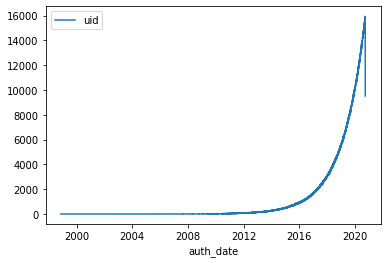

In [16]:
# Визуализируем датафрейм auth_df, чтобы посмотреть, на какой период приходится больше всего авторизаций

merged_data.groupby('auth_date').agg({'uid':'nunique'}).plot()

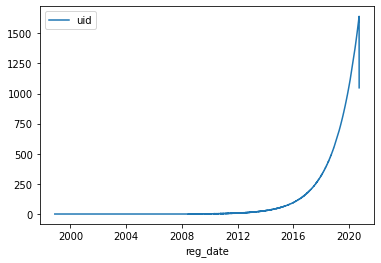

In [17]:
# Визуализируем датафрейм reg_df, чтобы посмотреть, на какой период приходится больше всего регистраций

merged_data.groupby('reg_date').agg({'uid':'nunique'}).plot()

In [18]:
merged_data.head()

,reg_date,uid,auth_date
0,1998-11-18,1,1998-11-18
1,1999-07-22,2,1999-07-22
2,1999-07-22,2,1999-07-25
3,1999-07-22,2,1999-07-31
4,1999-07-22,2,1999-08-05


In [19]:
# Теперь представим это в виде функции

def calculate_retention(reg_df, auth_df, start, end):
    
    # Преобразуем столбцы с временем в формат даты
    reg_df['reg_ts'] =  pd.to_datetime(reg_df.reg_ts)
    auth_df['auth_ts'] = pd.to_datetime(auth_df.auth_ts)
    reg_df['reg_ts'] =  pd.to_datetime((reg_df.reg_ts.dt.date))
    auth_df['auth_ts'] = pd.to_datetime(auth_df.auth_ts.dt.date)

    # Преобразуем новые переменные в формат даты
    start = pd.to_datetime(start).strftime('%Y-%m-%d')
    end   = pd.to_datetime(end).strftime('%Y-%m-%d')
    
    # Сделаем филтрацию исходных таблиц
    reg_df = reg_df.query('reg_ts >= @start and reg_ts <= @end')
    auth_df = auth_df.query('auth_ts >= @start and auth_ts <= @end')
    
    # Объединим данные из датафреймов "reg_df" и "auth_df" по идентификатору пользователя "uid" 
    merged_data = reg_df.merge(auth_df, on='uid', how='outer')
    
    # Меняем тип данных столбика uid
    merged_data['uid'] = merged_data['uid'].astype(int) 
    
    # Посчитаем разницу в днях для даты авторизации и регистрации
    merged_data['days'] = (merged_data.auth_ts - merged_data.reg_ts).dt.days
     
    # Когорты 
    cohorts = merged_data.groupby(['reg_ts', 'days']).agg({'uid':'nunique'})
    cohorts = cohorts.pivot_table(index='reg_ts', columns='days', values='uid')
    
    # Retention
    retention = cohorts.div(cohorts[0], axis=0).round(3)
    retention.iloc[:, 1:]
    
    # Визуализируем retention
    plt.figure(figsize=(20, 17))
    plt.title('Retention')
    sns.heatmap(retention, cmap="YlGnBu", vmin=0.0, vmax=0.1, fmt='.0%', annot=True)
    plt.show()
    
    return calculate_retention

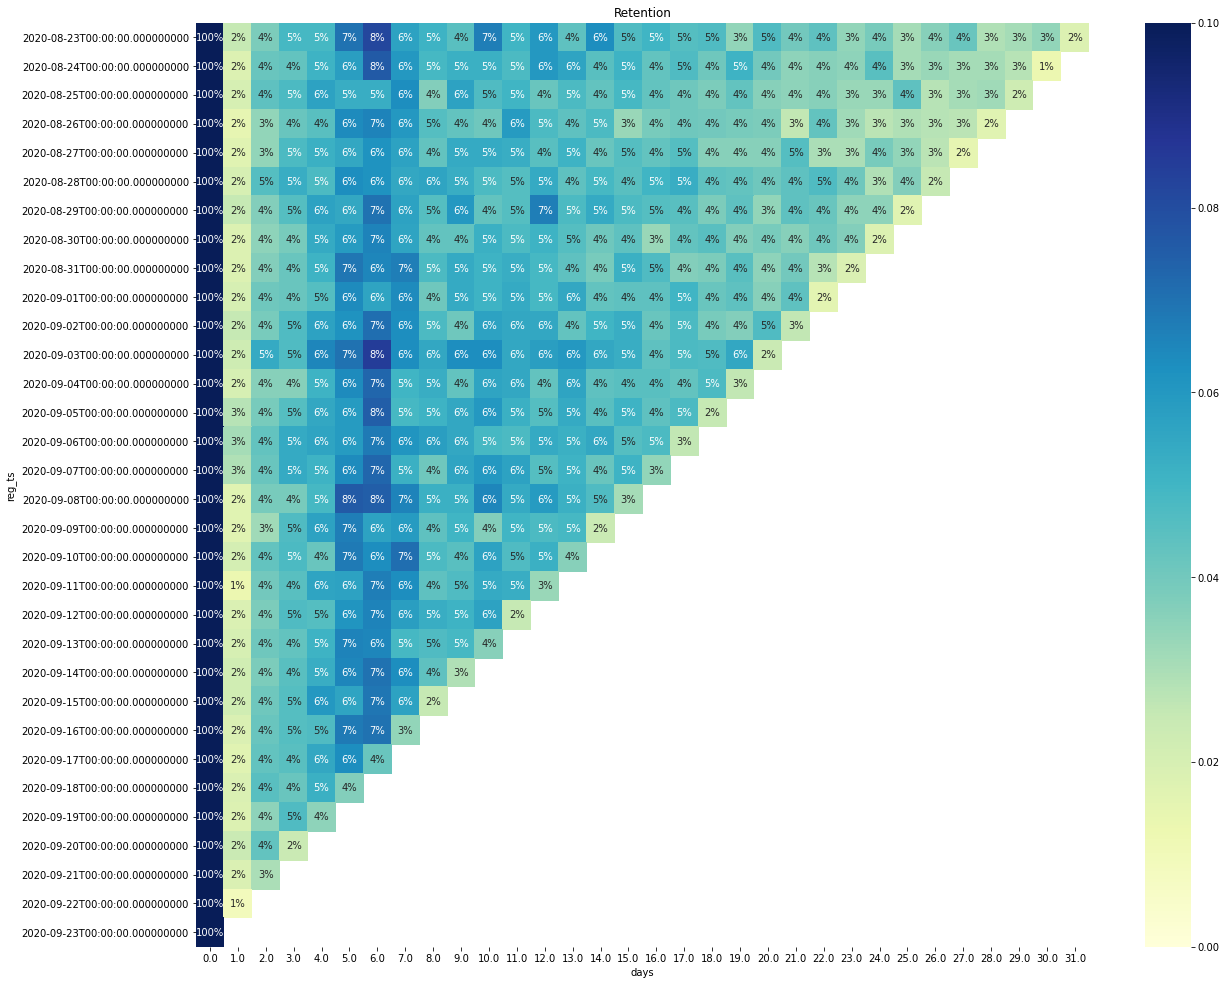

In [26]:
# Посмотрим retention за последний месяц

start = '2020-08-23'
end = '2020-09-23'

My_retention = calculate_retention(reg_df, auth_df, start, end)